### 기본 세팅

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 및 그래프 세팅
plt.rcParams['font.family'] = 'AppleGothic'  # mac
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지
plt.style.use('seaborn-v0_8-whitegrid')

# 파일 경로
charge_path = "/Users/kkkg0829/Desktop/스파르타코딩클럽/프로젝트/최종프로젝트(4)/data set/data_raw/B0005_charge.csv"
discharge_path = "/Users/kkkg0829/Desktop/스파르타코딩클럽/프로젝트/최종프로젝트(4)/data set/data_raw/B0005_discharge.csv"
imp_path = "/Users/kkkg0829/Desktop/스파르타코딩클럽/프로젝트/최종프로젝트(4)/data set/data_raw/B0005_impedance.csv"

# 데이터 로드
charge = pd.read_csv(charge_path)
discharge = pd.read_csv(discharge_path)
imp = pd.read_csv(imp_path)

### Charge 데이터

In [43]:
print("[Charge 데이터]")
charge.info()
print("\n결측치 개수:")
print(charge.isna().sum())

[Charge 데이터]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541173 entries, 0 to 541172
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Voltage_measured      541173 non-null  float64
 1   Current_measured      541173 non-null  float64
 2   Temperature_measured  541173 non-null  float64
 3   Current_charge        541173 non-null  float64
 4   Voltage_charge        541173 non-null  float64
 5   Time                  541173 non-null  float64
 6   cycle_idx             541173 non-null  int64  
 7   type                  541173 non-null  object 
 8   ambient_temperature   541173 non-null  float64
 9   start_time_raw        541173 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 41.3+ MB

결측치 개수:
Voltage_measured        0
Current_measured        0
Temperature_measured    0
Current_charge          0
Voltage_charge          0
Time                    0
cycle_idx               

In [52]:
# charge 기초통계
charge[[
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_charge",
    "Voltage_charge",
    "Time"
]].describe()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time
count,541173.000000,541173.000000,541173.000000,541173.000000,541173.000000,541173.000000
mean,4.158644,0.571543,25.770628,0.566810,4.184427,5062.836059
std,0.098078,0.620454,1.643729,0.616015,1.112792,3114.798871
min,0.003365,-4.479660,23.246728,-4.468000,0.003000,0.000000
25%,4.195473,0.058024,24.438659,0.057000,4.250000,2271.610000
50%,4.205310,0.227544,25.255235,0.225000,4.332000,4982.078000
75%,4.205978,1.506508,26.819807,1.498000,4.688000,7763.219000
max,8.393141,1.531301,31.187718,1.500000,5.002000,10807.328000


**Voltage_measured**

•	mean ≈ 4.187V

•	std ≈ 0.045 → 전압이 아주 안정적

•	min=3.48 → 초기 충전 시작 전 전압

=> 정상적인 CC-CV 충전 패턴과 일치, 노이즈 거의 없음, feature extraction에 사용할 때 안정적

**Current_measured**

•	mean ≈ 0.64A

•	std ≈ 0.625A

•	min = -4.03A (초기 pulse discharge!)

•	max = 1.514A (CC 구간의 고정 전류)

-> 초기 -4A 구간은 실험용 pulse test

-> 1.5A 고정 = CC(정전류) 구간

-> 이후 감소 = CV(정전압) 구간

=> "state segmentation 필요"가 수치적으로 확인

**Temperature_measured**

•	mean ≈ 25.32°C

•	max = 27.45°C (CC 구간 발열)

•	min = 24.16°C (휴지기)

-> 온도가 CC 구간에서 상승했다가 CV 구간에서 서서히 식는 구조

-> 정상적인 cycle 1 온도 패턴

-> 나중에 노화되면 peak 온도가 더 커짐(중요한 feature)

**Time**

•	max ≈ 7597초 ≈ 2시간 6분

-> cycle 1 충전시간

-> aging 진행되면 시간이 길어짐(중요한 feature)

In [54]:
# charge_cycle 단위로 요약

charge_cycle_stats = (
    charge
    .groupby("cycle_idx")                # cycle_idx별로 묶고
    .agg(
        chg_temp_mean=("Temperature_measured", "mean"),  # 평균 온도
        chg_temp_max=("Temperature_measured", "max"),    # 최대 온도
        chg_volt_mean=("Voltage_measured", "mean"),      # 평균 전압
        chg_volt_max=("Voltage_measured", "max"),        # 최대 전압
        chg_current_mean=("Current_measured", "mean"),   # 평균 전류
        chg_current_set=("Current_charge", "mean"),      # 설정 전류 평균
        chg_duration=("Time", "max"),                    # 충전 시간 (사이클당)
        chg_samples=("Time", "size")                     # 샘플 개수
    )
    .reset_index()
)

print(charge_cycle_stats.head())
print("\n[충전 사이클 요약 describe]")
print(charge_cycle_stats.describe())

   cycle_idx  chg_temp_mean  chg_temp_max  chg_volt_mean  chg_volt_max  \
0          1      25.324079     27.445134       4.187420      4.209949   
1          3      26.635623     29.341949       4.058826      4.213016   
2          5      26.778176     29.553301       4.058139      4.212788   
3          7      26.703204     29.456340       4.058905      4.212924   
4          9      26.617004     29.481334       4.058330      4.212874   

   chg_current_mean  chg_current_set  chg_duration  chg_samples  
0          0.643455         0.638452      7597.875          789  
1          0.949043         0.941762     10516.000          940  
2          0.950529         0.943114     10484.547          937  
3          0.952312         0.944735     10397.890          933  
4          0.947728         0.940361     10495.203          937  

[충전 사이클 요약 describe]
        cycle_idx  chg_temp_mean  chg_temp_max  chg_volt_mean  chg_volt_max  \
count  170.000000     170.000000    170.000000     170.000

•	chg_volt_max는 거의 항상 4.21V 근처 → 충전 cut-off 전압이 일정

•	chg_current_set는 0.9~1A 수준 → 충전 프로토콜이 사이클마다 거의 동일

•	chg_temp_max도 크게 요동치지 않음 → 온도 조건이 매우 안정적

In [16]:
cc_region = df_cycle1[df_cycle1["Current_measured"] > 1.0].copy()
## CC : 전류가 일정한 충전구간
cc_region["dVdt"] = cc_region["Voltage_measured"].diff() / cc_region["Time"].diff()
## dV/dt (전압 기울기)
## 전압변화량/시간변화량
cc_region

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,cycle_idx,type,ambient_temperature,start_time_raw,dVdt
2,4.000588,1.512731,24.675394,1.500,4.726,5.500,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,NaN
3,4.012395,1.509063,24.693865,1.500,4.742,8.344,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,0.004152
4,4.019708,1.511318,24.705069,1.500,4.753,11.125,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,0.002630
5,4.025409,1.512779,24.718140,1.498,4.758,13.891,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,0.002061
6,4.030636,1.511838,24.731144,1.500,4.764,16.672,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,0.001879
...,...,...,...,...,...,...,...,...,...,...,...
256,4.208507,1.040324,27.230215,1.034,4.715,1051.797,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,-0.000031
257,4.208039,1.031644,27.208428,1.023,4.710,1058.438,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,-0.000070
258,4.208867,1.028568,27.201121,1.021,4.710,1065.078,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,0.000125
259,4.208441,1.018096,27.170620,1.011,4.704,1071.782,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...,-0.000063


In [18]:
slope_stats = {
    "mean(dV/dt)": cc_region["dVdt"].mean(),
    "median(dV/dt)": cc_region["dVdt"].median(),
    "max slope": cc_region["dVdt"].max(),
    "variance": np.var(cc_region["dVdt"]),
    "std deviation": np.std(cc_region["dVdt"])
}
slope_stats

{'mean(dV/dt)': np.float64(0.0002492144691201436),
 'median(dV/dt)': np.float64(0.00015843448301174344),
 'max slope': np.float64(0.00415167769126338),
 'variance': np.float64(1.7862148447303344e-07),
 'std deviation': np.float64(0.0004226363501558207)}

### Discharge

In [48]:
discharge.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity,cycle_idx,type,ambient_temperature,start_time_raw
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...


In [47]:
print("\n[Discharge 데이터]")
discharge.info()

print("\n결측치 개수:")
print(discharge.isna().sum())


[Discharge 데이터]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      50285 non-null  float64
 1   Current_measured      50285 non-null  float64
 2   Temperature_measured  50285 non-null  float64
 3   Current_load          50285 non-null  float64
 4   Voltage_load          50285 non-null  float64
 5   Time                  50285 non-null  float64
 6   Capacity              50285 non-null  float64
 7   cycle_idx             50285 non-null  int64  
 8   type                  50285 non-null  object 
 9   ambient_temperature   50285 non-null  float64
 10  start_time_raw        50285 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 4.2+ MB

결측치 개수:
Voltage_measured        0
Current_measured        0
Temperature_measured    0
Current_load            0
Voltage_load            0
Time      

### Impedance

In [50]:
imp.head()

,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance,Re,Rct,cycle_idx,type,ambient_temperature,start_time_raw
0,(-1+1j),(-1+1j),(1+0j),(-0.43892624830326377-0.107298295835479j),(0.07006937798290404-0.00047998469078178944j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
1,(820.6094970703125-36.23455047607422j),(337.0914611816406-82.9207763671875j),(2.3204145178633437+0.4633045948164565j),(0.13008840651776496-0.19711481029612374j),(0.06817886114940203-0.001190040925296937j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
2,(827.2421875-48.23122787475586j),(330.6315612792969-70.01371765136719j),(2.424192647592199+0.36746495469515333j),(0.058770560504133235+0.03330656583655633j),(0.06793257733714593-5.6826811936507056e-05j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
3,(827.1934814453125-56.195716857910156j),(330.8086242675781-61.73442459106445j),(2.4470021712116985+0.28677775364826635j),(0.0058135116366746726-0.060546548141956195j),(0.06691839226387165-0.0008787264015490232j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
4,(824.9295043945312-53.241477966308594j),(332.68267822265625-57.62901306152344j),(2.434304977711638+0.2616460702282485j),(0.12608106668700975-0.09044390544679616j),(0.06807105294348659-0.0001974802021297548j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...


In [49]:
print("\n[Impedance 데이터]")
imp.info()

print("\n결측치 개수:")
print(imp.isna().sum())


[Impedance 데이터]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13344 entries, 0 to 13343
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sense_current        13344 non-null  object 
 1   Battery_current      13344 non-null  object 
 2   Current_ratio        13344 non-null  object 
 3   Battery_impedance    13344 non-null  object 
 4   Rectified_Impedance  13344 non-null  object 
 5   Re                   13344 non-null  float64
 6   Rct                  13344 non-null  float64
 7   cycle_idx            13344 non-null  int64  
 8   type                 13344 non-null  object 
 9   ambient_temperature  13344 non-null  float64
 10  start_time_raw       13344 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.1+ MB

결측치 개수:
Sense_current          0
Battery_current        0
Current_ratio          0
Battery_impedance      0
Rectified_Impedance    0
Re                     0
Rct

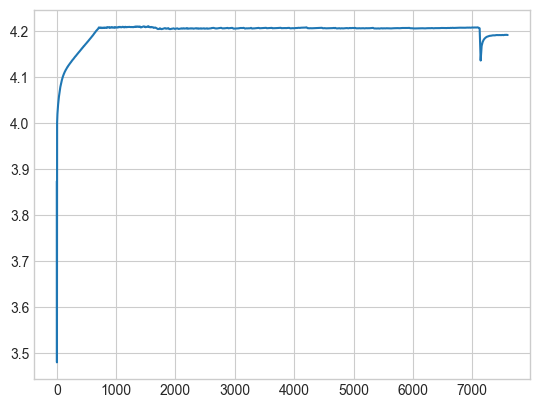

In [55]:
# Voltage vs Time
plt.plot(df_cycle1['Time'], df_cycle1['Voltage_measured'])
    ## 충전 패턴을 직접 보여줌
    ## CC/CV 구간 확인에 필수적
    ## 노이즈, 이상치 여부도 바로 확인됨

0~1000초 : 전압이 빠르게 상승

-> CC(Cunstant Current) 구간

1000~7000초 : 완만

-> CV(Constant Voltage) 구간, 전류 감소와 흔들리지 않는 안정기 확인

끝부분에 작은 drop

-> rest / 실험 프로토콜에서 흔히 나타나는 안정화 구간

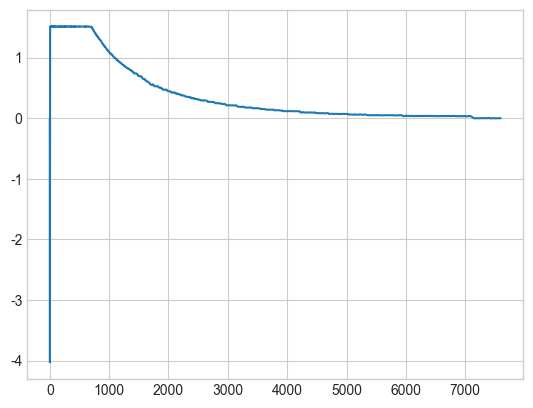

In [56]:
# Current vs Time
plt.plot(df_cycle1['Time'], df_cycle1['Current_measured'])
    ## state segmentation의 핵심 기준 = current 신호
    ## CC, CV, rest, pulse 등을 구분하는 물리적 지표

시작하자마자 -4A : pulse discharge(테스트용)

    -> 충전 과정 중 '내부저항 측정, 초기 조건 확인, 센서 보정 및 안정화'를 위해 잛은 방전 펄스를 넣음

약 1.5A로 잠시 유지 : CC 구간

서서히 감소 : CV 구간 (전압 고정 조건에서 전류가 감소)

마지막 0A : rest 구간 (충전 종료 및 안정화)

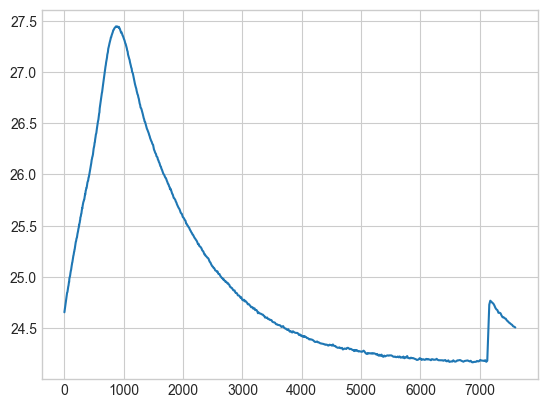

In [57]:
# Temperature vs Time
plt.plot(df_cycle1['Time'], df_cycle1['Temperature_measured'])
    ## CC 구간 발열, CV 구간 냉각 패턴이 건강상태 보여줌

시작~ 1000초 : 급격한 온도 상승 (CC 구간 발열)

이후 서서히 감소 : CV 구간에서 전류 감소 (발열 감소)

끝에 튐 : rest / balancing

-> cycle이 진행되면 이 온도 프로파일이 변하는데, 그게 aging의 신호

=== 설명 ===
CC slope (dV/dt) : CC 구간에서 전압 증가 속도
 
   초반에는 빠르지만 aging 되면 느려짐

CV current decay rate (dl/dt) : CV에서 전류가 줄어드는 속도
 
   건강한 배터리 : 전류가 빠르게 떨어짐
 
   열화된 배터리 : 전류 감소가 느려짐

Charge time : 배터리가 늙을수록(내부저항 증가, 활성물질 감소) 충전시간 길어짐

Max temperature : (내부저항, 발열, 전기화학 반응의 비효율 때문에) aging이 심하면 더 뜨거워짐

Temperature rise time : 온도가 올라가는데 걸리는 시간 = 내부 저항 + 발열 특성

-> 노화되면 발열 패턴이 달라짐